<a href="https://colab.research.google.com/github/anonyms/Kaggle_Titanic/blob/master/Kaggle_Titanic_Machine_Learning_for_Disaster_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from google.colab import files
from google.colab import data_table
seed = 4

Preparing folders

In [0]:
titanic_data_loctaion = "~/data/titanic/"
submission_file_name = "submissions.csv"
submission_file_location = titanic_data_loctaion + submission_file_name
!mkdir ~/data

Kaggle Set-up

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anoynms","key":"4b2c6afaefabfef48178035ff45d414b"}'}

In [4]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c titanic -p $titanic_data_loctaion

  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 47.1MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 55.7MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.20MB/s]


In [5]:
## Check files are there
!ls -l $titanic_data_loctaion

total 92
-rw-r--r-- 1 root root  3258 Feb 25 17:25 gender_submission.csv
-rw-r--r-- 1 root root 28629 Feb 25 17:25 test.csv
-rw-r--r-- 1 root root 61194 Feb 25 17:25 train.csv


Read data

In [0]:
train = pd.read_csv(titanic_data_loctaion + "train.csv")
test = pd.read_csv(titanic_data_loctaion + "test.csv")
output_sample = pd.read_csv(titanic_data_loctaion + "gender_submission.csv")
train.drop(["PassengerId"],axis=1,inplace=True)
test.drop(["PassengerId"],axis=1,inplace=True)
train.drop(["Name"],axis=1,inplace=True)
test.drop(["Name"],axis=1,inplace=True)

In [7]:
train.shape, test.shape

((891, 10), (418, 9))

In [0]:
train_copy = train.copy()
y = train_copy['Survived'].reset_index(drop=True)
train_features = train_copy.drop(['Survived'],axis=1)
features = pd.concat([train_features, test]).reset_index(drop=True)

In [0]:
## Output - Data Engineering
features['Embarked'].fillna(features.Embarked.mode()[0],inplace=True)
train['Embarked'].fillna(train.Embarked.mode()[0],inplace=True)
##features['Age'].fillna(features.groupby(['Pclass','Sex']).Age.transform('median'),inplace=True)
##train['Age'].fillna(train.groupby(['Pclass','Sex']).Age.transform('median'),inplace=True)
##ischild 10?

In [10]:
features.groupby(['Pclass','Sex']).Age.transform('median').sort_values()

654     22.0
1023    22.0
677     22.0
678     22.0
184     22.0
        ... 
925     42.0
252     42.0
919     42.0
985     42.0
911     42.0
Name: Age, Length: 1309, dtype: float64

In [11]:
data_table.DataTable(features,include_index=False,num_rows_per_page=15)

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,female,35.0,1,0,113803,53.1000,C123,S
4,3,male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
1304,3,male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1,female,39.0,0,0,PC 17758,108.9000,C105,C
1306,3,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,3,male,NaN,0,0,359309,8.0500,NaN,S


In [12]:
data_table.DataTable(train,include_index=False,num_rows_per_page=15)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,211536,13.0000,NaN,S
887,1,1,female,19.0,0,0,112053,30.0000,B42,S
888,0,3,female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,1,1,male,26.0,0,0,111369,30.0000,C148,C


Pclass
Number of null values: 0
Number of nan values: 0


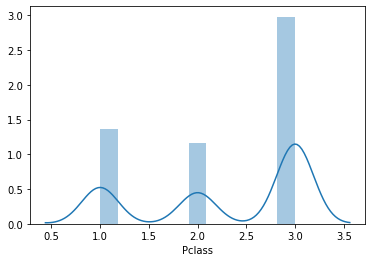

Sex
Number of null values: 0
Number of nan values: 0
['male' 'female']
Age
Number of null values: 263
Number of nan values: 263


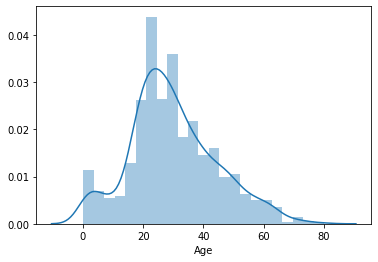

SibSp
Number of null values: 0
Number of nan values: 0


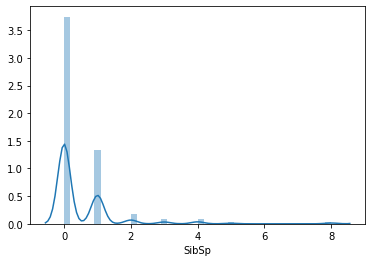

Parch
Number of null values: 0
Number of nan values: 0


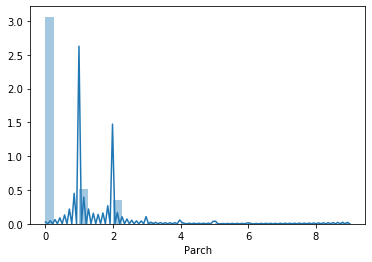

Ticket
Number of null values: 0
Number of nan values: 0
['A/5 21171' 'PC 17599' 'STON/O2. 3101282' '113803' '373450' '330877'
 '17463' '349909' '347742' '237736' 'PP 9549' '113783' 'A/5. 2151'
 '347082' '350406' '248706' '382652' '244373' '345763' '2649' '239865'
 '248698' '330923' '113788' '347077' '2631' '19950' '330959' '349216'
 'PC 17601' 'PC 17569' '335677' 'C.A. 24579' 'PC 17604' '113789' '2677'
 'A./5. 2152' '345764' '2651' '7546' '11668' '349253' 'SC/Paris 2123'
 '330958' 'S.C./A.4. 23567' '370371' '14311' '2662' '349237' '3101295'
 'A/4. 39886' 'PC 17572' '2926' '113509' '19947' 'C.A. 31026' '2697'
 'C.A. 34651' 'CA 2144' '2669' '113572' '36973' '347088' 'PC 17605' '2661'
 'C.A. 29395' 'S.P. 3464' '3101281' '315151' 'C.A. 33111' 'S.O.C. 14879'
 '2680' '1601' '348123' '349208' '374746' '248738' '364516' '345767'
 '345779' '330932' '113059' 'SO/C 14885' '3101278' 'W./C. 6608'
 'SOTON/OQ 392086' '343275' '343276' '347466' 'W.E.P. 5734' 'C.A. 2315'
 '364500' '374910' 'PC 17754' '

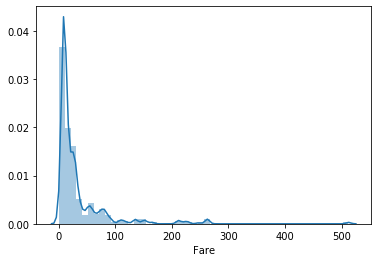

Cabin
Number of null values: 1014
Number of nan values: 1014
[nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C5

In [13]:
## View distribution of values for ALL columns
for i in features.columns:
  print(i)
  print("Number of null values:",features[i].isnull().sum())
  print("Number of nan values:",features[i].isna().sum())
  if features[i].dtypes == "object":
    print(features[i].unique())
  else:
    sns.distplot(features.loc[features[i].notnull(),i])
    plt.show()

Stupid Simple Eval functions - for my own testing's sake

In [0]:
features['Pclass'] = features['Pclass'].apply(str)
train['Pclass'] = train['Pclass'].apply(str)

In [15]:
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
objects

['Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [16]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
numerics

['Age', 'SibSp', 'Parch', 'Fare']

In [17]:
train.describe()

,Survived,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,29.699118,0.523008,0.381594,32.204208
std,0.486592,14.526497,1.102743,0.806057,49.693429
min,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,80.000000,8.000000,6.000000,512.329200


In [18]:
train.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      0
dtype: int64

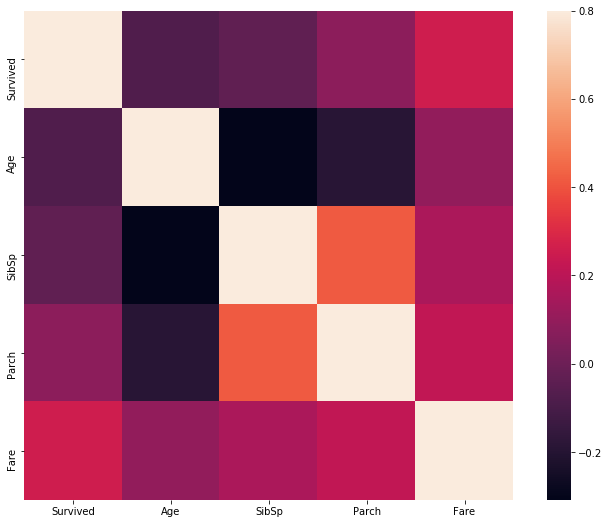

In [19]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

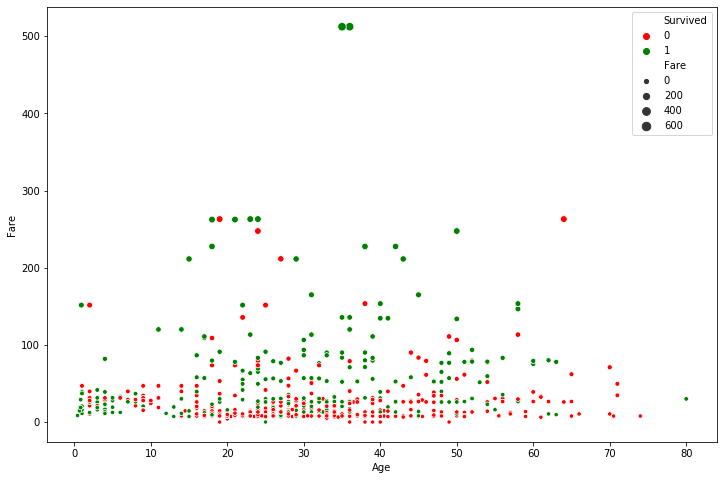

In [20]:
plt.rcParams['figure.figsize'] = (12,8)
sns.scatterplot(train.Age,train.Fare,hue=train.Survived,size=train.Fare,palette={0:'red',1:'green'});

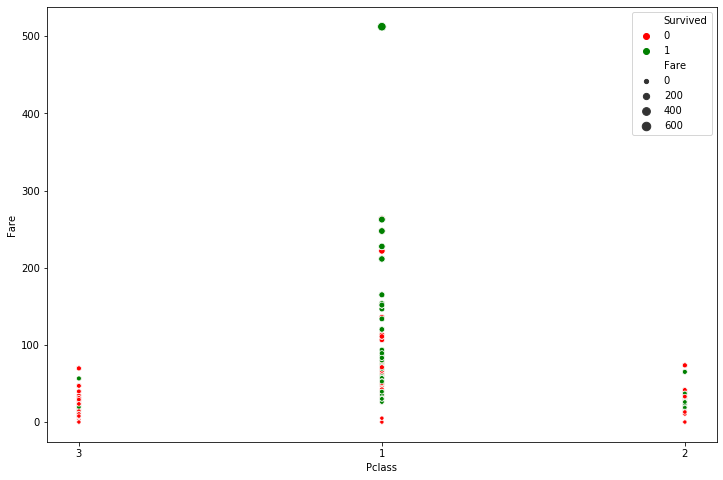

In [21]:
plt.rcParams['figure.figsize'] = (12,8)
sns.scatterplot(train.Pclass,train.Fare,hue=train.Survived,size=train.Fare,palette={0:'red',1:'green'});

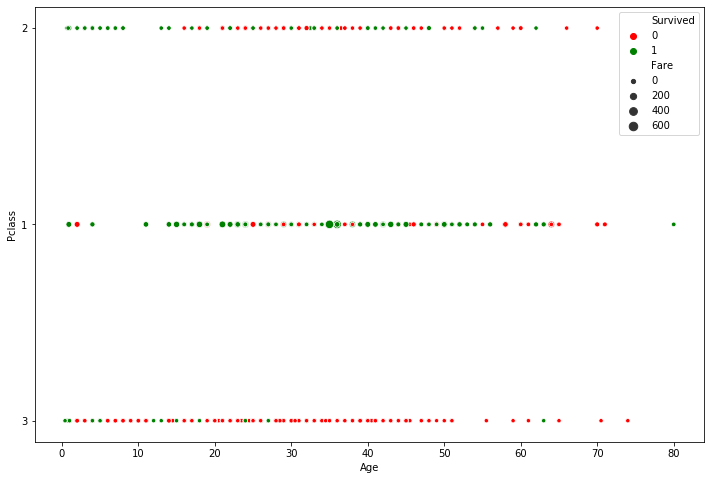

In [22]:
plt.rcParams['figure.figsize'] = (12,8)
sns.scatterplot(train.Age,train.Pclass,hue=train.Survived,size=train.Fare,palette={0:'red',1:'green'});

In [0]:
train['GenderCode'] = train.Sex.map({'male':0,'female':1})
train['FamilySize'] = train.SibSp + train.Parch + 1
train['isAlone'] = train.FamilySize==1
train['hasCabin'] = ~train.Cabin.isna()
train['Embarked'] = train.Embarked.map({'C':3.0,'Q':2.1,'S':1.8}).astype(np.float64)
train['AgeBin'] = pd.cut(train.Age,bins=8).cat.codes
train['FareBin'] = pd.cut(train.Fare,bins=15).cat.codes
train['isKid'] = train.Age<=10.0

In [24]:
train['Embarked']

0      1.8
1      3.0
2      1.8
3      1.8
4      1.8
      ... 
886    1.8
887    1.8
888    1.8
889    3.0
890    2.1
Name: Embarked, Length: 891, dtype: float64

In [0]:
def plot_feature(train_df,feature):
    survived_df = train_df[train_df.Survived==True][feature].value_counts()
    dead_df = train_df[train_df.Survived==False][feature].value_counts()
    counts_df = pd.DataFrame([survived_df,dead_df],index=['Survived','Dead'])
    counts_df.plot(kind='barh',stacked=True,legend=True,title='Frequency by '+feature)
    (counts_df.div(counts_df.sum(axis=1),axis=0)*100).plot(kind='barh',stacked=True,legend=True,title='Proportion by '+feature)
    
def plot_kde(train_df,split_feature,kde_feature):
    legend = sorted(train_df.dropna(subset=[split_feature])[split_feature].unique())
    for key in legend:
        sns.kdeplot(train_df[train_df[split_feature]==key][kde_feature],shade=True)#.plot(kind='kde',legend=True)
    plt.legend(tuple(legend))

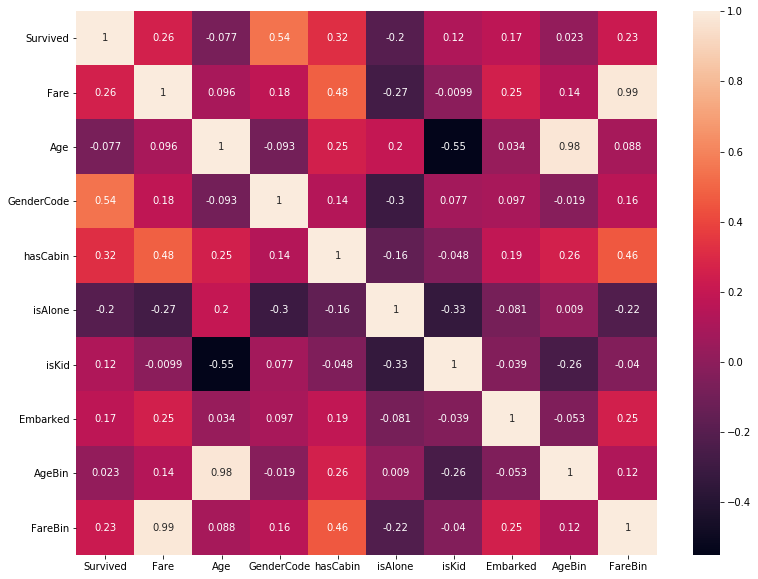

In [26]:
plt.rcParams['figure.figsize'] = (13,10)
sns.heatmap(train[['Survived','Pclass','Fare','Age','GenderCode','hasCabin','isAlone','isKid','Embarked','AgeBin','FareBin']].corr(),annot=True);

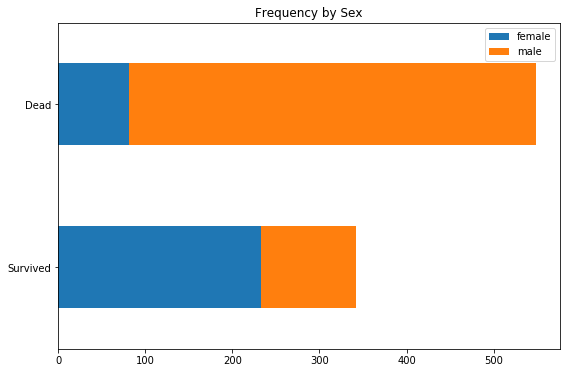

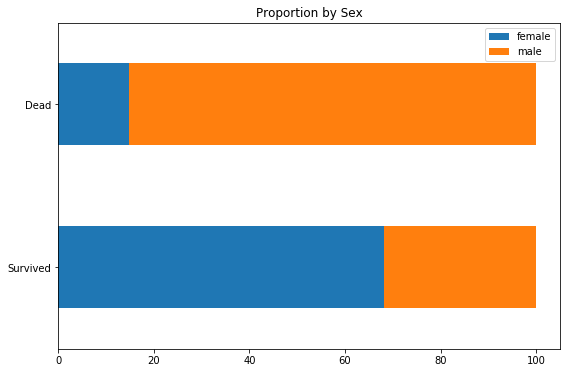

In [27]:
plt.rcParams['figure.figsize'] = (9,6)
plot_feature(train,'Sex')

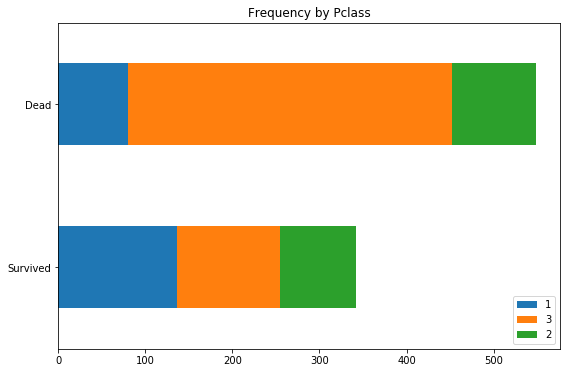

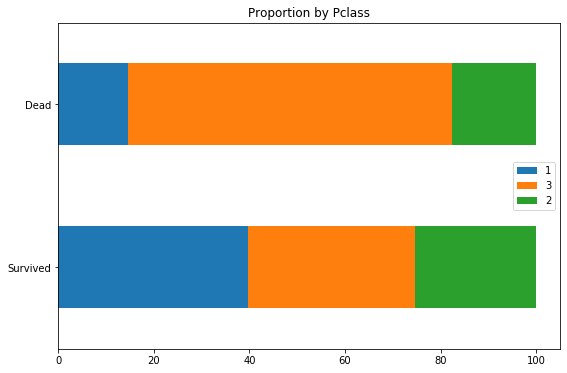

In [28]:
plot_feature(train,'Pclass')

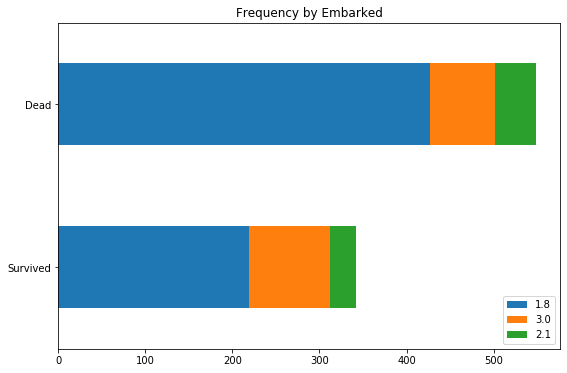

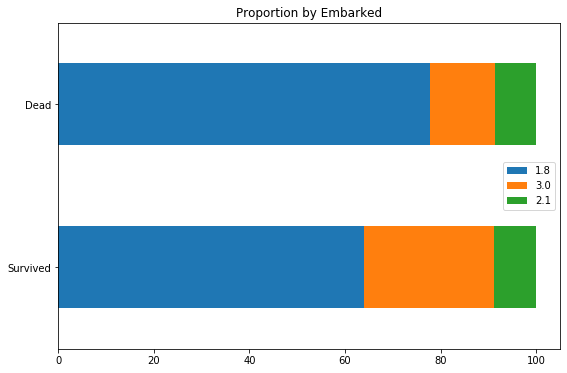

In [29]:
plot_feature(train,'Embarked')

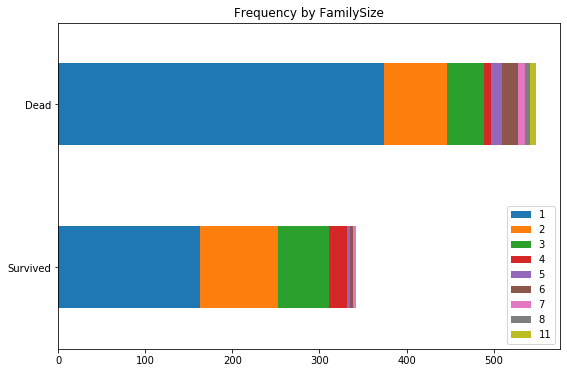

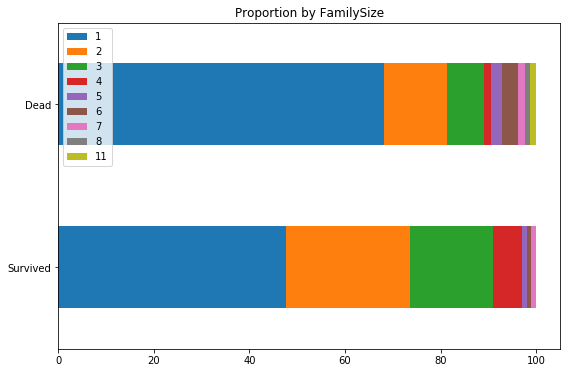

In [30]:
plot_feature(train,'FamilySize')

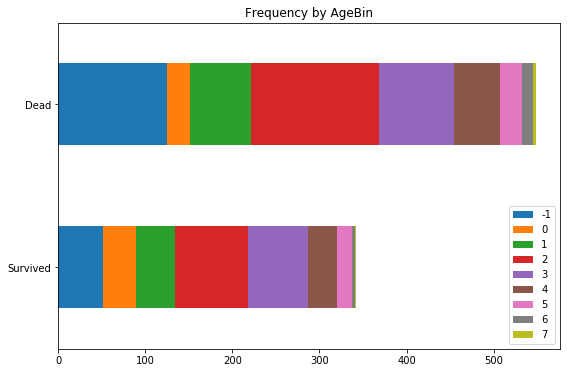

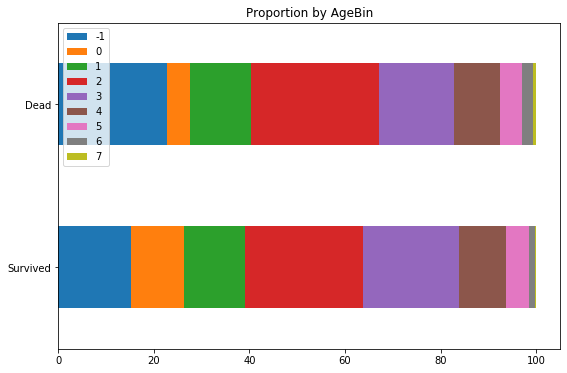

In [31]:
plot_feature(train,'AgeBin')

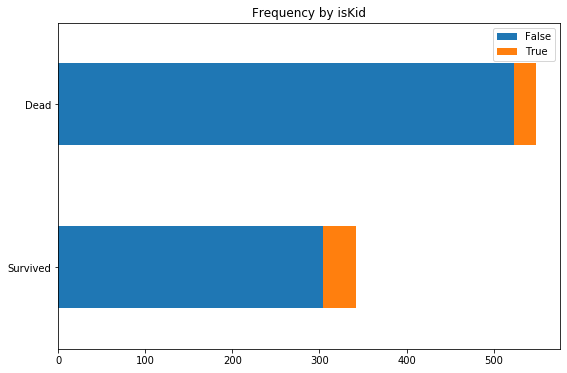

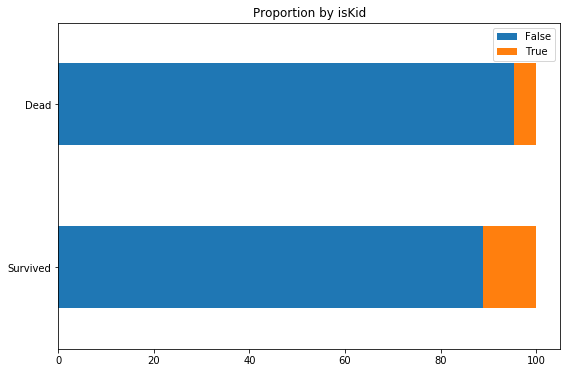

In [32]:
plot_feature(train,'isKid')

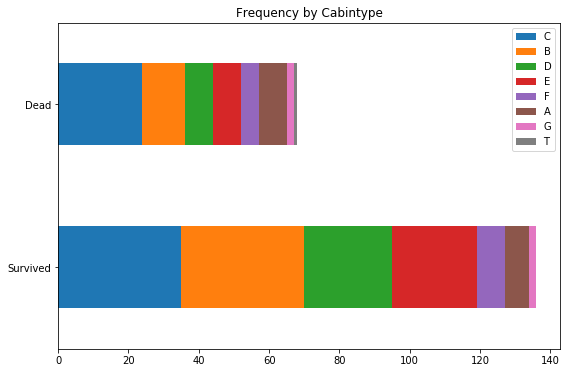

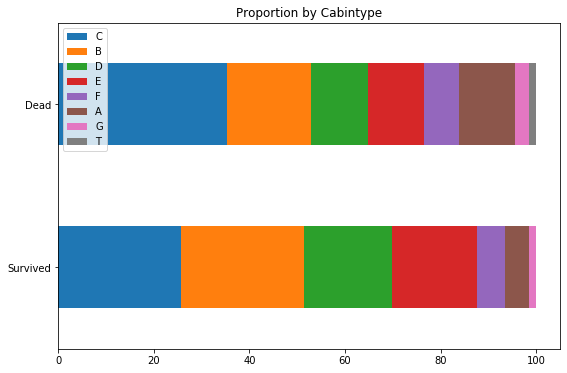

In [33]:
train['Cabintype'] = train['Cabin'].str[0]
plot_feature(train,'Cabintype')

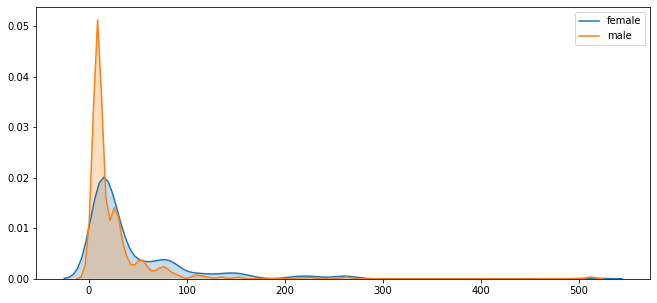

In [34]:
plt.rcParams['figure.figsize'] = (11,5)
plt.clf()
plot_kde(train,'Sex','Fare')
plt.show()

In [35]:
train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean()

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [40]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908
